In [1]:
import os
from rasterio import features
import matplotlib.pyplot as plt
import rasterio
from rasterio import plot
from osgeo import gdal, ogr
import geopandas as gpd
%matplotlib inline

In [2]:
PRODUCT_PATH = 'S2A_MSIL1C_20150725T112046_N0204_R037_T29TNE_20150725T112540.SAFE/'
BANDS_PATH = PRODUCT_PATH+'/GRANULE/L1C_T29TNE_A000463_20150725T112540/IMG_DATA/'
COS_PATH = 'COS2015-V1-PT16E_Regiao_Coimbra/COS2015-V1-PT16E_Regiao_Coimbra.shx'

In [55]:
band1 = rasterio.open(BANDS_PATH+'T29TNE_20150725T112046_B01.jp2', driver='JP2OpenJPEG')
transf = band1.meta['transform']

In [56]:
band1.meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'width': 1830,
 'height': 1830,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:32629'),
 'transform': Affine(60.0, 0.0, 499980.0,
        0.0, -60.0, 4500000.0)}

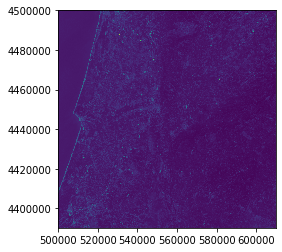

In [57]:
plot.show(band1)
plt.show()

In [58]:
matrix_shape = band1.height, band1.width

x_min, y_max = band1.xy(0,0)
x_max, y_min = band1.xy(band1.height,band1.width)


In [59]:

dict(band1.meta['crs'])

{'init': 'epsg:32629'}

In [60]:
band1.read(1)

array([[1234, 1241, 1243, ..., 1071, 1062, 1108],
       [1233, 1249, 1237, ..., 1084, 1103, 1162],
       [1255, 1263, 1240, ..., 1198, 1165, 1124],
       ...,
       [1292, 1281, 1267, ..., 1237, 1184, 1144],
       [1266, 1181, 1185, ..., 1198, 1136, 1126],
       [1268, 1183, 1168, ..., 1198, 1113, 1130]], dtype=uint16)

In [61]:
band1.read(1).shape


(1830, 1830)

In [9]:
rst = rasterio.open('examplefile.tiff', 'w', driver='Gtiff',
                          width=band1.width, height=band1.height,
                          count=1,
                          crs=band1.crs,
                          transform=band1.transform,
                          dtype='uint16'
                         )
rst.write(band1.read(1),1)
rst.close()


In [62]:


gdf = gpd.read_file('./cos_coimbra_new_crs/cos_coimbra_new_crs.shx')

shapes = ((geom, value) for geom, value in zip(gdf['geometry'], gdf['Megaclasse']))

burned = features.rasterize(
    shapes=shapes,
    out_shape=band1.read(1).shape,
    fill=-1,
    transform=transf,
    all_touched=False,
    default_value=1,
    dtype='int32',
)

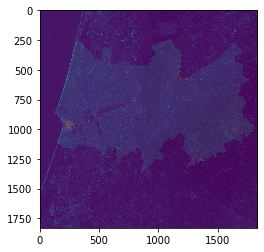

In [64]:
plt.imshow(band1.read(1))#, cmap='Reds')
plt.imshow(burned, alpha=0.2)
plt.show()

In [45]:
def get_mask(filename):
    vector_fn = filename
    print(vector_fn)
    # Define pixel_size and NoData value of new raster
    pixel_size = 30
    NoData_value = -9999
        
    # Open the data source and read in the extent
    source_ds = ogr.Open(vector_fn)
    source_layer = source_ds.GetLayer()
    x_min, x_max, y_min, y_max = source_layer.GetExtent()
        
    print(source_layer.GetExtent())
    # Create the destination data source
    x_res = int((x_max - x_min) / pixel_size)
    y_res = int((y_max - y_min) / pixel_size)
    print(x_res, y_res)
    target_ds = gdal.GetDriverByName(str('MEM')).Create('', x_res, y_res, gdal.GDT_Byte)
    target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(NoData_value)
        
    # Rasterize
    gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1])
        
    # Read as array
    array = band.ReadAsArray()
    return array 

In [ ]:

get_mask('./cos_coimbra_new_crs/cos_coimbra_new_crs.shp')


In [11]:

gpd.read_file('./cos_coimbra_new_crs/cos_coimbra_new_crs.shx')


NameError: name 'gpd' is not defined

In [38]:

x_min, y_max, x_max, y_min

(500010.0, 4499970.0, 609810.0, 4390170.0)

In [3]:
from get_data_matrix import product_reader

PRODUCT_PATH = 'S2A_MSIL1C_20150725T112046_N0204_R037_T29TNE_20150725T112540.SAFE/'
BANDS_PATH = PRODUCT_PATH+'/GRANULE/L1C_T29TNE_A000463_20150725T112540/IMG_DATA/'
COS_PATH = 'COS2015-V1-PT16E_Regiao_Coimbra/COS2015-V1-PT16E_Regiao_Coimbra.shx'

coimbrinhas = product_reader(bands_path=BANDS_PATH, labels_shapefile=COS_PATH, label_col='Megaclasse')
X = coimbrinhas.get_X_array()
y = coimbrinhas.get_y_array()


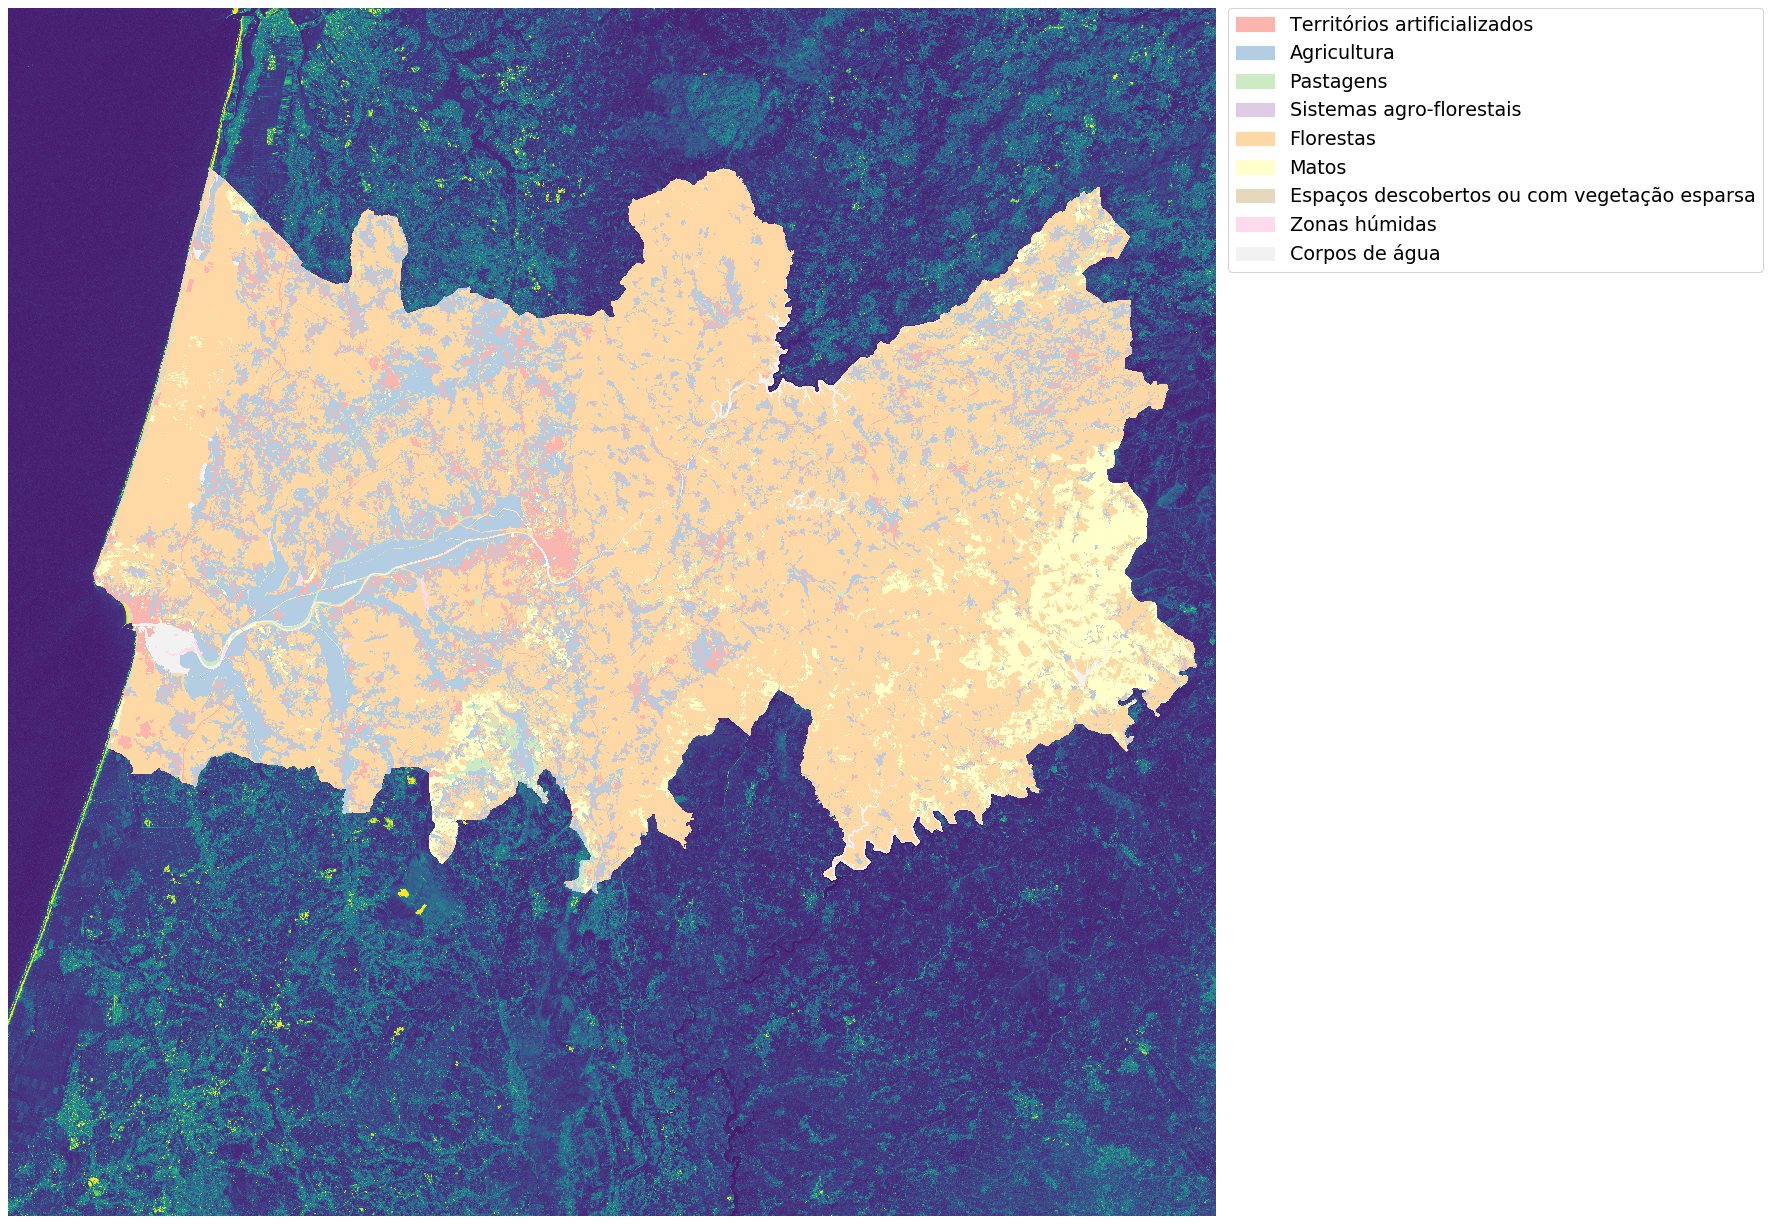

In [6]:
coimbrinhas.plot(coimbrinhas.bands[10], alpha=1)

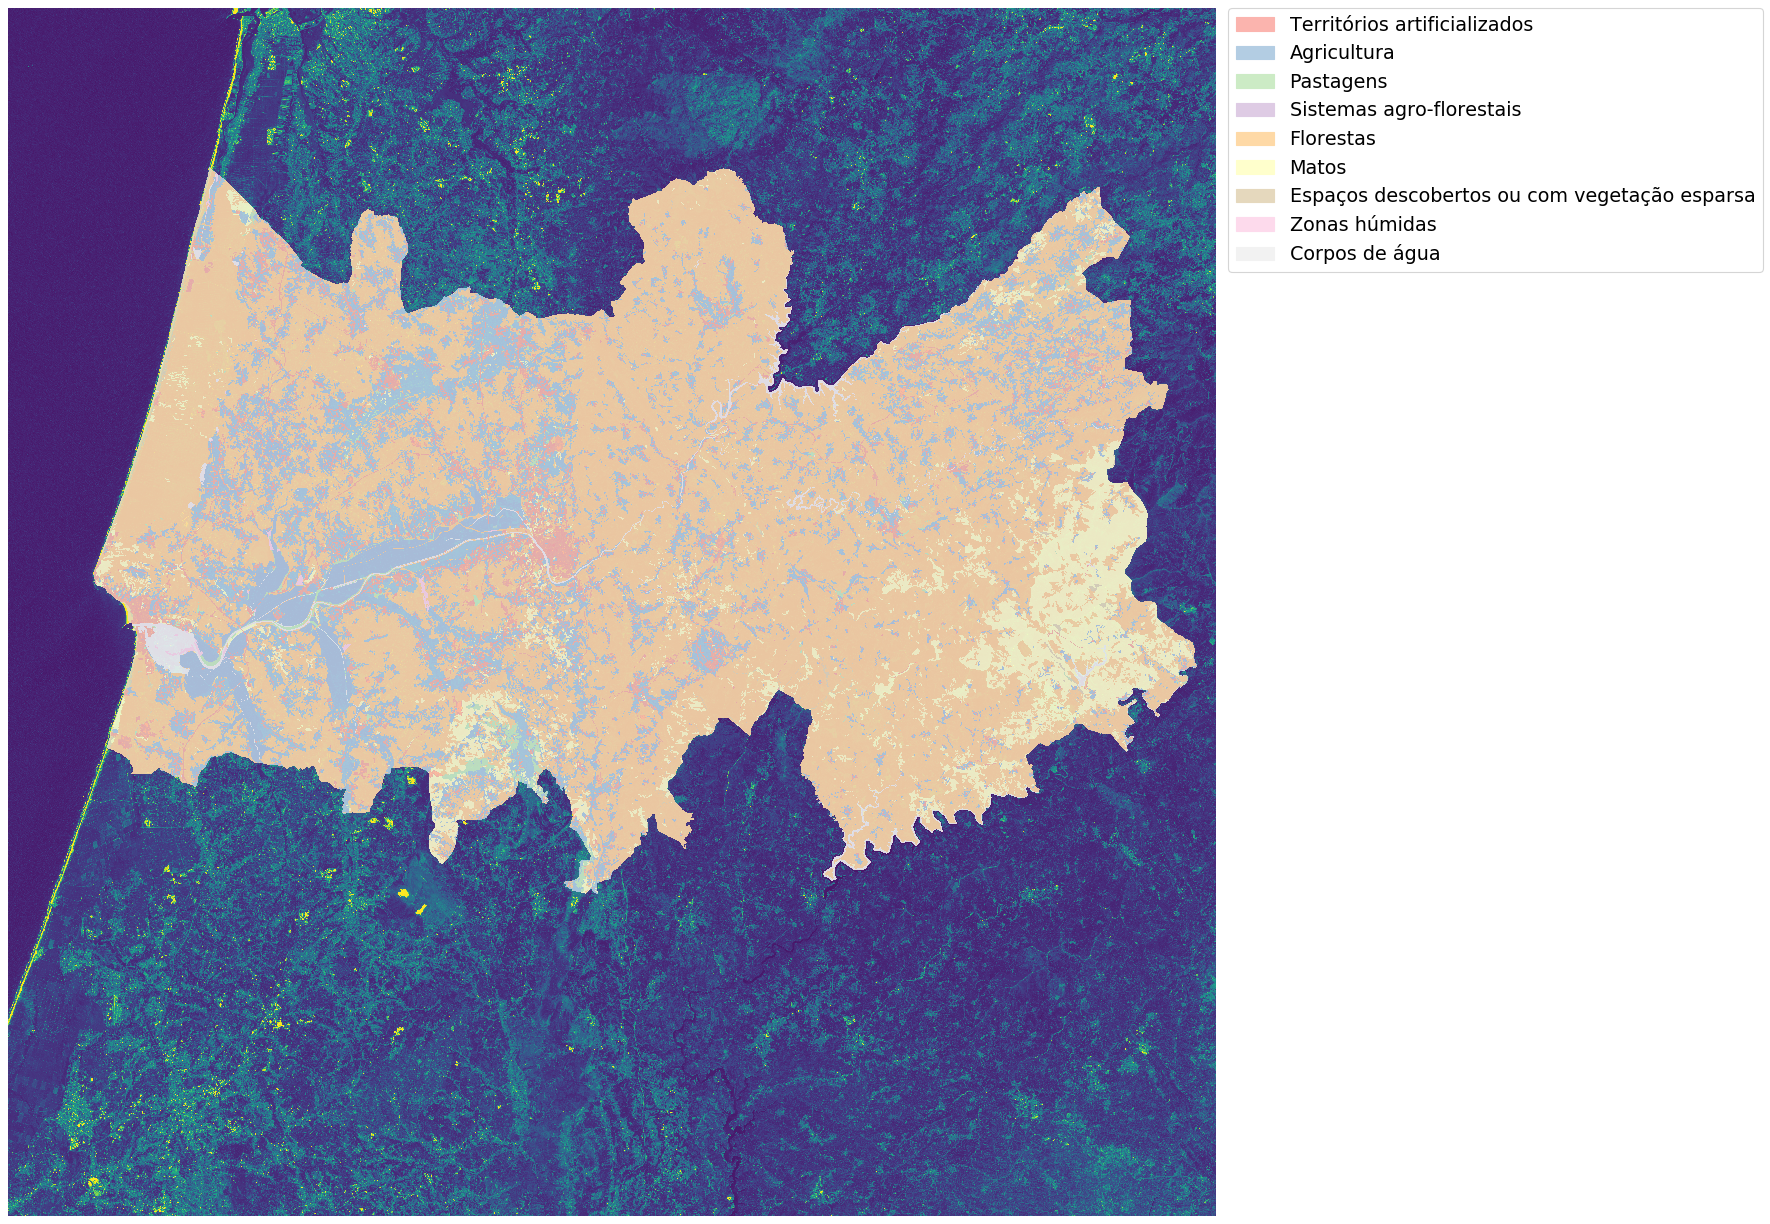

In [101]:
plt.figure(
    figsize=(20,20),
    dpi=80
)
plt.imshow(
    X[10]
)
im = plt.imshow(
    np.ma.masked_where(y == -1, y),
    alpha=0.9,
    cmap='Pastel1'
)
plt.axis('off')

values = list(coimbrinhas.y_labels.values())
labels = list(coimbrinhas.y_labels.keys())

colors = [ im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label=f'{labels[i]}' ) for i in values]
plt.legend(
    handles=patches, 
    bbox_to_anchor=(1.01, 1), 
    loc=2, 
    borderaxespad=0.,
    fontsize='xx-large'
)
plt.show()